# Support Vector Machines

## Exercice 1 : Classification

### 1.a)
Using the representer theorem seen in class we jnow that $f \in Span(k(x_1,\cdot),\dots,k(x_n,\cdot))$. 

Therefore noting $K(i,j):=k(x_i,x_j)$, the Lagrangian of the problem can be written : $$\mathbb{L}(w,b,\xi,\alpha,\mu)=\frac{1}{2}w^{T}Kw + C \sum_{i=1}^{N}\xi_i+\sum_{i=1}^{N} \alpha_i [(1-\xi_i)-y_i([Kw]_i+b)] - \sum_{i=1}^{N}\mu_i \xi_i$$

### 1.b)

The dual minimization problem is 
\begin{align} 
 \underset{\alpha}{min} \ &\frac{1}{2}\alpha^{T}K\alpha - \sum_{i=1}^{N}\alpha_i \\
s.t. \ &\ 0 \leq \alpha_i \leq C, \ \forall i \in \{1 ,\dots,N\} \\
&\alpha^{T}y=0
\end{align}

Noting $\alpha^{*}$ the minimizer and $D$ the diagonal matrix s.t $D(i,i)=y_i$, we have that $f(x)=\sum_{i=1}^{N} k(x,x_i)(D\alpha^{*})_i$

### 1.c)

If $0<\alpha_i<C$ then $y_i([K \alpha]_i +b)=1$

In [9]:
import numpy as np
import pickle as pkl
from scipy import optimize
from scipy.linalg import cho_factor, cho_solve
import matplotlib.pyplot as plt
from utils import plotClassification, plotRegression, plot_multiple_images, generateRings, scatter_label_points, loadMNIST
from scipy.spatial.distance import cdist


## Loading the data

The file 'classification_datasets' contains 3 small classification datasets:
    
    - dataset_1: mixture of two well separated gaussians
    - dataset_2: mixture of two gaussians that are not separeted
    - dataset_3: XOR dataset that is non-linearly separable.
   
Each dataset is a hierarchical dictionary with the following structure:
        
        dataset = {'train': {'x': data, 'y':label}
                    'test': {'x': data, 'y':label}
                  }
The data $x$ is an $N$ by $2$ matrix, while the label $y$ is a vector of size $N$. 

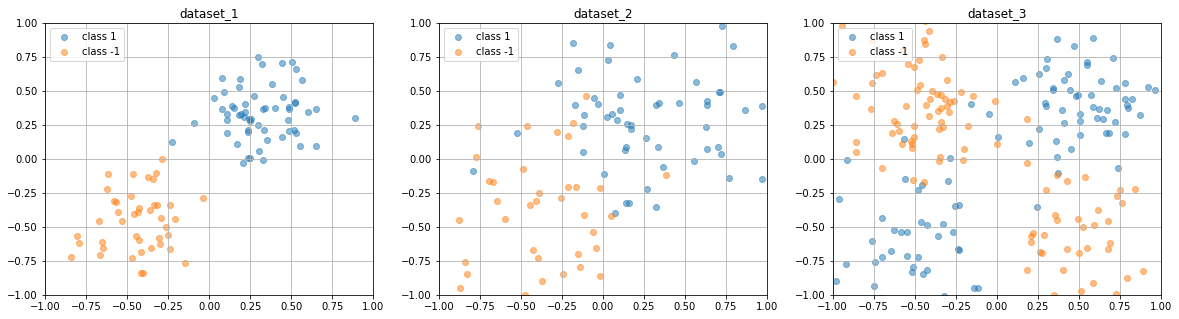

In [10]:
file = open('datasets/classification_datasets', 'rb')
datasets = pkl.load(file)
file.close()
fig, ax = plt.subplots(1,3, figsize=(20, 5))
for i, (name, dataset) in enumerate(datasets.items()):
    
    plotClassification(dataset['train']['x'], dataset['train']['y'], ax=ax[i])
    ax[i].set_title(name)


## III- Kernel SVC 
### 1- Implementing the Gaussian Kernel
Implement the method 'kernel' of the class RBF below, which takes as input two data matrices $X$ and $Y$ of size $N\times d$ and $M\times d$ and returns a gramm matrix $G$ of shape $N\times M$ whose components are $k(x_i,y_j) = \exp(-\Vert x_i-y_i\Vert^2/(2\sigma^2))$. (The fastest solution does not use any for loop!)

In [11]:
class RBF:
    def __init__(self, sigma=1.):
        self.sigma = sigma  ## the variance of the kernel
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        dists = cdist(X, Y , metric="euclidean")
        K = np.exp(-0.5 * dists /(sigma**2))
        return K
    
class Linear:
    
    def __init__(self):
        return
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        
        return X@Y.T ## Matrix of shape NxM"""
    


### 2- Implementing the classifier
Implement the methods 'fit' and 'separating_function' of the class KernelSVC below to learn the Kernel Support Vector Classifier.

In [25]:
class KernelSVC:
    
    def __init__(self, C, kernel, epsilon = 1e-3):
        self.type = 'non-linear'
        self.C = C                               
        self.kernel = kernel        
        self.alpha = None
        self.lamb = None
        self.support = None
        self.epsilon = epsilon
        self.norm_f = None
       
    
    def fit(self, X, y):
       #### You might define here any variable needed for the rest of the code
        N = len(y)
        D=np.diag(y)
        K=self.kernel(X,X)
        
        # Lagrange dual problem
        def loss(alpha):
            return  0.5*alpha.T@D@K@D@alpha - np.sum(alpha)         #'''--------------dual loss ------------------ '''
        
        # Partial derivate of Ld on alpha
        def grad_loss(alpha):
            return D@K@D@alpha - np.ones(alpha.shape)# '''----------------partial derivative of the dual loss wrt alpha-----------------'''


        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0
        
        fun_eq = lambda alpha:  alpha@y # '''----------------function defining the equality constraint------------------'''        
        jac_eq = lambda alpha:   y #'''----------------jacobian wrt alpha of the  equality constraint------------------'''
        fun_ineq = lambda alpha:  np.concatenate((self.C*np.ones(N),np.zeros(N)),axis=0)+np.concatenate((-np.eye(N),np.eye(N)),axis=0)@alpha # '''---------------function defining the ineequality constraint-------------------'''     
        jac_ineq = lambda alpha:  np.concatenate((-np.eye(N),np.eye(N)),axis=0) # '''---------------jacobian wrt alpha of the  inequality constraint-------------------'''
        
        
        constraints = ({'type': 'eq',  'fun': fun_eq, 'jac': jac_eq},
                       {'type': 'ineq', 
                        'fun': fun_ineq , 
                        'jac': jac_ineq})

        optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda alpha: grad_loss(alpha), 
                                   constraints=constraints)
        self.alpha = optRes.x

        ## Assign the required attributes
        
        
        marginIndices = np.nonzero((self.alpha>self.epsilon) *(self.alpha < self.C-self.epsilon))
        
        supportIndices = np.nonzero(self.alpha>self.epsilon)
        self.support = X[supportIndices] #'''------------------- A matrix with each row corresponding to a support vector ------------------'''
        k=marginIndices[0][0]
        j=marginIndices[0]
        
        self.b = y[k]-(K@D@self.alpha)[k]  #''' -----------------offset of the classifier------------------ '''
        
        self.norm_f = self.alpha.T@D@K@D@self.alpha # '''------------------------RKHS norm of the function f ------------------------------'''
        self.lamb = (D@self.alpha)[supportIndices]

    ### Implementation of the separting function $f$ 
    def separating_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        
        a = self.kernel(x,self.support)@self.lamb
        
        return a
    
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        d = self.separating_function(X)
        return 2 * (d+self.b> 0) - 1

### 2- Fitting the classifier

Run the code block below to fit the classifier and report its output.

Number of support vectors = 2
Number of support vectors = 25
Number of support vectors = 57


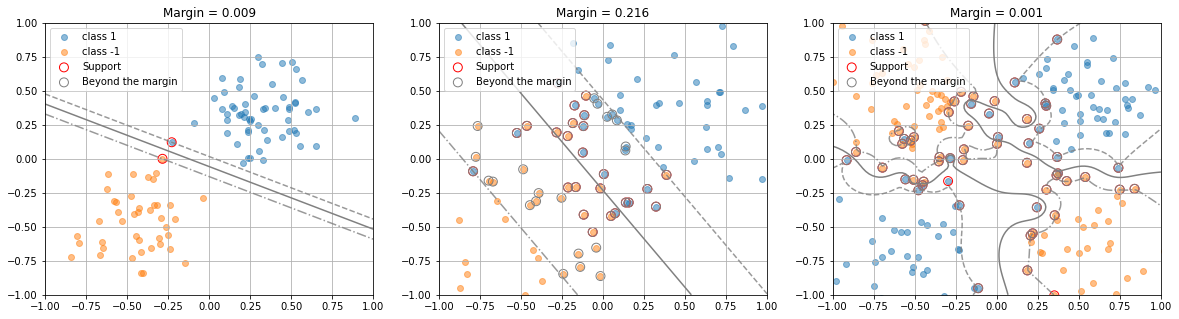

In [26]:
fig, ax = plt.subplots(1,3, figsize=(20, 5))
C = 10000.
kernel = Linear().kernel
model = KernelSVC(C=C, kernel=kernel)
train_dataset = datasets['dataset_1']['train']

model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training', ax = ax[0])

C = 10.
model = KernelSVC(C=C, kernel=kernel)
train_dataset = datasets['dataset_2']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training', ax = ax[1])


sigma = 1.5
C=100.
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel)
train_dataset = datasets['dataset_3']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training', ax=ax[2])


## Exercice 2 : Kernel Regression

### 1.a)
Using the representer theorem seen in class we jnow that $f \in Span(k(x_1,\cdot),\dots,k(x_n,\cdot))$. 

Therefore noting $K(i,j):=k(x_i,x_j)$ and $D$ the diagonal matrix s.t $D(i,i)=y_i$,   the Lagrangian of the problem can be written : $$\mathbb{L}(w,b,\xi_i,\alpha,\mu)=\frac{1}{2}w^{T}Kw + C \sum_{i=1}^{N}(\xi_i+\xi_i^{*})-\sum_{i=1}^{N} \alpha_i [\epsilon+\xi_i-y_i+[Kw]_i+b] -\sum_{i=1}^{N} \alpha_i^{*} [\epsilon+\xi_i^{*}+y_i-[Kw]_i-b]- \sum_{i=1}^{N}(\mu_i \xi_i+\mu_i^{*}\xi_i^{*})$$

### 1.b)

The dual minimization problem is 
\begin{align} 
 \underset{\alpha}{min} \ &\frac{1}{2}(\alpha-\alpha^{*})^{T}K(\alpha - \alpha^{*})+ \epsilon  \sum_{i=1}^{N}(\alpha_i + \alpha_i^{*}) - y^{T}(\alpha-\alpha^{*})\\
s.t. \ &\ 0 \leq \alpha_i,\alpha_i^{*} \leq C, \ \forall i \in \{1 ,\dots,N\} \\
&\sum_{i=1}^{N}(\alpha_i-\alpha_i^{*})=0
\end{align}

Noting $\alpha^{*}$ the minimizer, we have that $f(x)=\sum_{i=1}^{N} k(x,x_i)(\alpha_i-\alpha_i^{*})+b$

### 1.c)

If $0<\alpha_i<C$ then $y_i -[K \alpha]_i - b= \epsilon$ 

If $0<\alpha_i^{*}<C$ then $y_i -[K \alpha^{*}]_i - b= - \epsilon$ 

## Loading the data

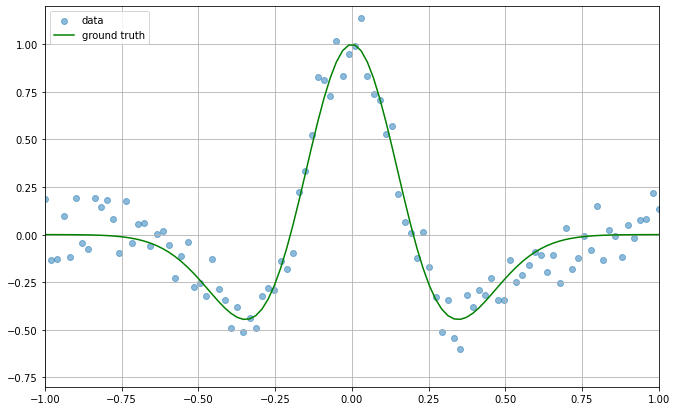

In [201]:
file = open('datasets/regression_datasets', 'rb')
datasets = pkl.load(file)
file.close()
train_set = datasets['dataset_1']['train']
train_set = datasets['dataset_1']['test']
plotRegression(train_set['x'], train_set['y'],Y_clean= train_set['y_clean'])


## Kernel  Support Vector Regression
### 1- Implementing the regressor
Implement the method 'fit' of the classes KernelSVR below to perform Kernel Support Vector Regression. 


In [202]:
class KernelSVR:
    
    def __init__(self, C, kernel, eta= 1e-2, epsilon = 1e-3):
        self.C = C                               
        self.kernel = kernel  
        self.alpha = None # Vector of size 2*N
        self.support = None
        self.eta = eta
        self.epsilon = epsilon
        self.eps = 0.
        self.type='svr'
        
    def fit(self, X, y):
        
        #### You might define here any variable needed for the rest of the code
        N = len(y)
        K=self.kernel(X,X)
        U=np.concatenate((np.ones(N),-np.ones(N)),axis=0)
        
        # Lagrange dual problem
        def loss(alpha):
            alpha_N = alpha[0:N]-alpha[N:]
            return  0.5*alpha_N.T@K@alpha_N + self.eta*np.sum(alpha) -  y@alpha_N #'''--------------dual loss ------------------ '''

        # Partial derivate of Ld on alpha
        def grad_loss(alpha):
            alpha_N = alpha[0:N]-alpha[N:]
            return np.concatenate((K@alpha_N,-K@alpha_N),axis=0)+ self.eta*np.ones(2*N) - np.concatenate((y,-y),axis=0)
            
        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0
        fun_eq = lambda alpha: alpha@U# '''----------------function defining the equality constraint------------------'''        
        jac_eq = lambda alpha: U    #'''----------------jacobian wrt alpha of the  equality constraint------------------'''
        fun_ineq = lambda alpha:  np.concatenate((self.C*np.ones(2*N),np.zeros(2*N)),axis=0)+np.concatenate((-np.eye(2*N),np.eye(2*N)),axis=0)@alpha # '''---------------function defining the ineequality constraint-------------------'''     
        jac_ineq = lambda alpha:  np.concatenate((-np.eye(2*N),np.eye(2*N)),axis=0) # '''---------------jacobian wrt alpha of the  inequality constraint-------------------'''
        
        constraints = ({'type': 'eq',  'fun': fun_eq, 'jac': jac_eq},
                       {'type': 'ineq', 'fun': fun_ineq , 'jac': jac_ineq})
        
        optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                   x0= self.C*np.ones(2*N),
                                   method='SLSQP', 
                                   jac=lambda alpha: grad_loss(alpha), 
                                   constraints=constraints, 
                                   tol=1e-7)
        self.alpha = optRes.x
        self.alpha_N = self.alpha[0:N]-self.alpha[N:]
        ## Assign the required attributes
        
        marginIndices = np.nonzero((self.alpha > self.epsilon)*(self.alpha<self.C-self.epsilon))
        k=marginIndices[0][0]
        self.b = y[k]-self.eta-(K@self.alpha_N)[k]    #''' -----------------offset of the regressor ------------------ '''
        
        supportIndices = np.nonzero(np.abs(K@self.alpha_N + self.b - y)>self.eta-self.epsilon) #'''------------------- A matrix with each row corresponding to a support vector ------------------'''
        Y=y[supportIndices].reshape((-1,1))
        self.support = np.concatenate((X[supportIndices],Y),axis=1)
        self.support2 = X[supportIndices]
        #self.support = self.support.flatten()
        self.lamb = self.alpha_N[supportIndices] 
    ### Implementation of the separting function $f$ 
    def regression_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        return self.kernel(x,self.support2)@self.lamb
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        return self.regression_function(X)+self.b
    

### 2- Fitting the regressor

Run the code block below to fit the regressor and report its output.

Number of support vectors = 45


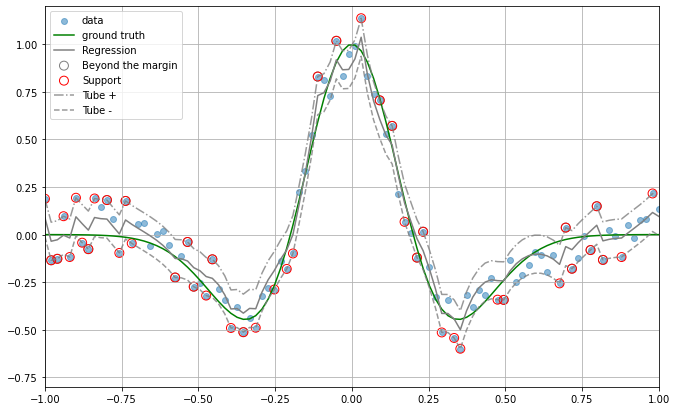

In [203]:
sigma = 0.2
C = 10.
kernel = RBF(sigma).kernel
model = KernelSVR(C,kernel, eta= .1, epsilon = 1e-3)
model.fit(train_set['x'].reshape(-1,1),train_set['y'])
plotRegression(train_set['x'], train_set['y'], Y_clean= train_set['y_clean'], model=model, label='Train')